<a href="https://colab.research.google.com/github/KylixEza/BeU-DL/blob/master/BeU_Notebook_Mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import InputLayer
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.regularizers import L1
from keras.regularizers import L2
from keras.regularizers import L1L2
import tensorflow_hub as hub

In [3]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
!rm -rf ./logs/
tf.summary.create_file_writer("./logs/")

# Preprocessing

In [6]:
dataset_dir = '/content/gdrive/MyDrive/datasets/Indonesian Food Mini/'

In [9]:
import os
from os import listdir
from PIL import Image
import PIL
  

directories = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

for directory in directories:
  for filename in listdir(dataset_dir+directory+'/'):
    try:
      img = Image.open(dataset_dir+directory+'/'+filename)
    except PIL.UnidentifiedImageError as e:
      print(f"Error: {filename} is not a valid image file.")

In [10]:
import splitfolders
splitfolders.ratio(dataset_dir, output="datasets", seed=123, ratio=(0.7, 0.15, 0.15)) 

Copying files: 1296 files [00:12, 105.36 files/s]


In [11]:
train_dir = 'datasets/train/'
val_dir = 'datasets/val'
test_dir = 'datasets/test'

In [72]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    vertical_flip=True,
    horizontal_flip=True
)

In [73]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [74]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

Found 906 images belonging to 5 classes.


In [75]:
validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
)

Found 192 images belonging to 5 classes.


In [76]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
)

Found 198 images belonging to 5 classes.


In [77]:
train_generator.class_indices

{'bakso': 0, 'bubur': 1, 'capcay': 2, 'nasi goreng': 3, 'telur balado': 4}

# Modelling

In [78]:
size = len(train_generator.class_indices)
model = Sequential([
    InputLayer(input_shape=(224, 224) + (3,)),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5", trainable=True),
    Dense(size, activation='softmax', activity_regularizer=L1L2(l1=1e-5, l2=1e-5))
])

In [79]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 1001)              5508713   
                                                                 
 dense_5 (Dense)             (None, 5)                 5010      
                                                                 
Total params: 5,513,723
Trainable params: 5,489,323
Non-trainable params: 24,400
_________________________________________________________________


In [80]:
class AccuracyCallback(Callback):
  def on_epoch_end(self, epoch, logs=None):
       if(logs.get('accuracy') > 0.98 and logs.get('val_accuracy') > 0.97):      
          self.model.stop_training = True

accuracy_callback = AccuracyCallback()

In [81]:
model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [82]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    verbose=2,
    callbacks=[accuracy_callback]
)

Epoch 1/30
29/29 - 114s - loss: 1.2819 - accuracy: 0.6203 - val_loss: 1.2300 - val_accuracy: 0.7135 - 114s/epoch - 4s/step
Epoch 2/30
29/29 - 25s - loss: 0.5643 - accuracy: 0.9128 - val_loss: 0.9074 - val_accuracy: 0.8438 - 25s/epoch - 853ms/step
Epoch 3/30
29/29 - 22s - loss: 0.4395 - accuracy: 0.9625 - val_loss: 0.7998 - val_accuracy: 0.8490 - 22s/epoch - 764ms/step
Epoch 4/30
29/29 - 24s - loss: 0.4067 - accuracy: 0.9669 - val_loss: 0.5681 - val_accuracy: 0.9271 - 24s/epoch - 818ms/step
Epoch 5/30
29/29 - 24s - loss: 0.3703 - accuracy: 0.9812 - val_loss: 0.5155 - val_accuracy: 0.9427 - 24s/epoch - 828ms/step
Epoch 6/30
29/29 - 24s - loss: 0.3356 - accuracy: 0.9934 - val_loss: 0.4844 - val_accuracy: 0.9531 - 24s/epoch - 827ms/step
Epoch 7/30
29/29 - 24s - loss: 0.3310 - accuracy: 0.9923 - val_loss: 0.4947 - val_accuracy: 0.9531 - 24s/epoch - 816ms/step
Epoch 8/30
29/29 - 22s - loss: 0.3242 - accuracy: 0.9945 - val_loss: 0.4595 - val_accuracy: 0.9531 - 22s/epoch - 770ms/step
Epoch 9/3

#Plot

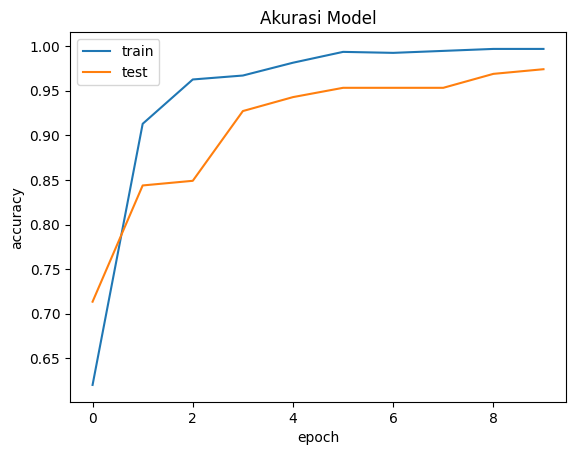

In [83]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

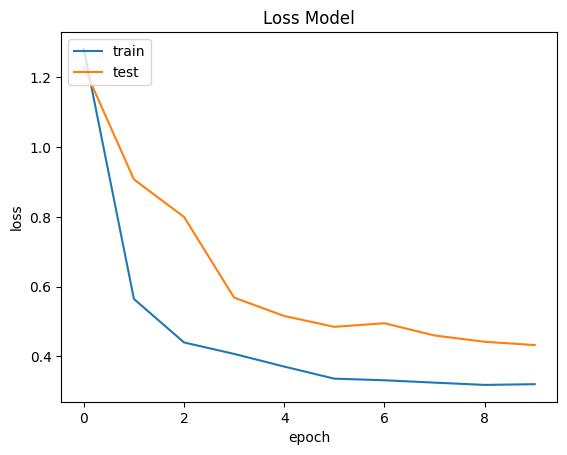

In [84]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Export

In [85]:
#for tflite
import pathlib
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('beu_mini.tflite')
tflite_model_file.write_bytes(tflite_model)

22008468

In [99]:
model.save('beu_mini_model', save_format='h5')

#Quantization

In [100]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
with open('/content/beu_mini_quantized.tflite', 'wb') as f:
  f.write(tflite_quant_model)

#Github

In [ ]:
%cd gdrive/MyDrive/Lomba/BeU

In [ ]:
!git init

In [139]:
!git add BeU_Notebook_Mini.ipynb

In [148]:
!git config --global user.email "kylixeza.dev@gmail.com"
!git config --global user.name "KylixEza"

In [ ]:
!git commit -m "add beu notebook for mini size model"

In [ ]:
!git remote add origin https://github.com/KylixEza/BeU-DL.git

In [ ]:
!git push -u origin master